# Importando base de dados

In [1]:
import pandas as pd
import numpy as np

RAMDOM_STATE = 11

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/VitorBonella/PL-Dataset/main/dataset.csv',sep=";") #Leitura dos dados para o pandas

In [3]:
df.set_index('id',inplace=True) #Transformando a coluna id no indice da tabela

#Observem que a classe esta separada em duas colunas então devemos concatenadas para formar uma coluna só chamada classe
df['classe'] = df['tipo_lampada'].str.replace(" ", "") + df['potencia'].astype(str) 

In [4]:
# Lista de Indices
FOURIER = ['df01', 'df02', 'df03', 'df04','df05', 'df06', 'df07', 'df08', 'df09', 'df10']
HU = ['i1', 'i2', 'i3', 'i4','i5', 'i6', 'i7']
HARALICK = ['probmax', 'energia', 'entropia', 'contraste','homogeneidade', 'correlacao']
ALL = FOURIER + HU + HARALICK
MY = HU

df[ALL] = df[ALL].apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)

X = df[MY]
Y = df['classe']

In [5]:
results_df = pd.DataFrame(columns=['Método', 'Média', 'Desvio padrão', 'Limite inf.', 'Limite sup.'])

# Treinando classificadores

### zeroR

In [6]:
from sklearn.model_selection import cross_val_predict 
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy import stats

zR = DummyClassifier(strategy='most_frequent', random_state=RAMDOM_STATE)

cv_zR = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RAMDOM_STATE)

scores_ZR = cross_val_score(zR, X, Y, scoring='accuracy', cv=cv_zR)

inf, sup = stats.norm.interval(0.95, loc=scores_ZR.mean(), scale=scores_ZR.std()/np.sqrt(len(scores_ZR)))

results_df = pd.concat([results_df, pd.DataFrame({'Método': ['ZR'], 'Média': [scores_ZR.mean()], 'Desvio padrão': scores_ZR.std(), 'Limite inf.': inf, 'Limite sup.': sup})], ignore_index=True)

### Função para treinar classificadores

In [7]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats

def train_models(model, params_grid):
    scaler = StandardScaler()
    pipe = Pipeline(steps=[('scaler',scaler), ('model', model)])

    inner_cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=RAMDOM_STATE)

    outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RAMDOM_STATE)

    grid_search = GridSearchCV(pipe, param_grid=params_grid,  scoring='accuracy', cv=inner_cv, n_jobs=-1)

    scores = cross_val_score(grid_search, X, Y.values.ravel(), scoring='accuracy', cv=outer_cv, n_jobs=-1)

    return scores

### Bagging

In [8]:
from sklearn.ensemble import BaggingClassifier

bg = BaggingClassifier(n_estimators=3, random_state=RAMDOM_STATE)

params_grid = {
    'model__n_estimators': [3,9,15,21]
    } 

scores_BA = train_models(bg, params_grid)

inf, sup = stats.norm.interval(0.95, loc=scores_BA.mean(), scale=scores_BA.std()/np.sqrt(len(scores_BA)))

results_df = pd.concat([results_df, pd.DataFrame({'Método': ['BA'], 'Média': [scores_BA.mean()], 'Desvio padrão': scores_BA.std(), 'Limite inf.': inf, 'Limite sup.': sup})], ignore_index=True)

### AdaBoost

In [9]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=3, random_state=RAMDOM_STATE)

params_grid = {
    'model__n_estimators': [3,9,15,21]
    }

scores_AD = train_models(ada, params_grid)

inf, sup = stats.norm.interval(0.95, loc=scores_AD.mean(), scale=scores_AD.std()/np.sqrt(len(scores_AD)))

results_df = pd.concat([results_df, pd.DataFrame({'Método': ['AD'], 'Média': [scores_AD.mean()], 'Desvio padrão': scores_AD.std(), 'Limite inf.': inf, 'Limite sup.': sup})], ignore_index=True)

### RandomForest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=RAMDOM_STATE)

params_grid = {
    'model__n_estimators': [3,9,15,21]
}

scores_RF = train_models(rf, params_grid)

inf, sup = stats.norm.interval(0.95, loc=scores_RF.mean(), scale=scores_RF.std()/np.sqrt(len(scores_RF)))

results_df = pd.concat([results_df, pd.DataFrame({'Método': ['RF'], 'Média': [scores_RF.mean()], 'Desvio padrão': scores_RF.std(), 'Limite inf.': inf, 'Limite sup.': sup})], ignore_index=True)

In [11]:
results_df

,Método,Média,Desvio padrão,Limite inf.,Limite sup.
0,ZR,0.165057,0.010883,0.161163,0.168952
1,BA,0.461571,0.096206,0.427145,0.495997
2,AD,0.257165,0.027720,0.247246,0.267084
3,RF,0.472797,0.074776,0.446039,0.499555


### Criando classificador HeterogeneousPooling

In [12]:
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.validation import check_X_y
from sklearn.utils import resample
from collections import Counter

class HeterogeneousPooling(BaseEstimator):
    # define o construtor para o classificador
    def __init__(self, n_samples=3):
        self.classifiers = [DecisionTreeClassifier(random_state=RAMDOM_STATE), KNeighborsClassifier(), GaussianNB()]
        self.n_samples = n_samples
        self.trained_classifiers = []

    def fit(self, X, y):
        # cria uma lista com as classes ordenadas crescentemente pela frequência
        self.counter = sorted(Counter(Y).items(), key=lambda x: x[1], reverse=True)

        # treina os classificadores
        for i in range(self.n_samples):
            if i == 0:
                X_train = X
                y_train = y
            else:
                X_train, y_train = resample(X, y, replace=True, random_state=i)

            self.train_classifiers(X_train, y_train)
        return self
    
    def train_classifiers(self, X, y):
        
        for classifier in self.classifiers:
            classifier.fit(X, y.ravel())
            self.trained_classifiers.append(classifier)

    def predict(self, X_test):
        if(isinstance(X_test, np.ndarray)):
            X_test = pd.DataFrame(X_test)
        predictions = []

        for _, row in X_test.iterrows():
            predictions.append(self.unique_predict(row))

        return predictions

    def unique_predict(self, X):
        predictions = {}

        X = X.to_numpy().reshape(1, -1)

        for classifier in self.trained_classifiers:
            pred = classifier.predict(X)
            if pred[0] not in predictions:
                predictions[pred[0]] = 1
            else:
                predictions[pred[0]] += 1
        
        # verificar se existe mais de uma classe com a mesma quantidade de votos
        max_votes = max(predictions.values())
        max_classes = [k for k, v in predictions.items() if v == max_votes]

        if len(max_classes) > 1:
            # se sim, retornar a classe mais frequenter na base de treino entre as classes com mais votos
            for key in self.counter:
                if key in max_classes:
                    return key

        # se não, retornar a classe mais votada
        return max_classes[0]


In [13]:
hp = HeterogeneousPooling()

params_grid = {
    'model__n_samples': [1,3,5,7]
}

scores_HP = train_models(hp, params_grid)

inf, sup = stats.norm.interval(0.95, loc=scores_HP.mean(), scale=scores_HP.std()/np.sqrt(len(scores_HP)))

results_df = pd.concat([results_df, pd.DataFrame({'Método': ['HP'], 'Média': [scores_HP.mean()], 'Desvio padrão': scores_HP.std(), 'Limite inf.': inf, 'Limite sup.': sup})], ignore_index=True)

In [14]:
results_df

,Método,Média,Desvio padrão,Limite inf.,Limite sup.
0,ZR,0.165057,0.010883,0.161163,0.168952
1,BA,0.461571,0.096206,0.427145,0.495997
2,AD,0.257165,0.027720,0.247246,0.267084
3,RF,0.472797,0.074776,0.446039,0.499555
4,HP,0.384100,0.093748,0.350553,0.417646


In [15]:
from scipy import stats 

scores = [scores_ZR, scores_BA, scores_AD, scores_RF, scores_HP]
nomes_modelos = ['ZeroR', 'BA', 'AB', 'RF', 'HP']

qtd_modelos = 5

cmp_resultados = {}

for i in range(qtd_modelos):
    cmp_resultados[i] = {}
    for j in range(i+1, qtd_modelos):
        ttest = stats.ttest_rel(scores[i], scores[j])
        wilcoxon = stats.wilcoxon(scores[i], scores[j], method='approx')
        # save results
        cmp_resultados[i][j] = {'ttest': ttest[1], 'wilcoxon': wilcoxon[1]}

# tabela com os resultados dos testes, t student no superior e wilcoxon no inferior
tabela_pareada = pd.DataFrame(columns=nomes_modelos, index=nomes_modelos)

for i in range(qtd_modelos):
    for j in range(i, qtd_modelos):
        if i == j:
            tabela_pareada.loc[nomes_modelos[i], nomes_modelos[j]] = nomes_modelos[i]

        else:
            tabela_pareada.loc[nomes_modelos[i], nomes_modelos[j]] = cmp_resultados[i][j]['ttest']
            tabela_pareada.loc[nomes_modelos[j], nomes_modelos[i]] = cmp_resultados[i][j]['wilcoxon']

tabela_pareada

,ZeroR,BA,AB,RF,HP
ZeroR,ZeroR,0.0,0.0,0.0,0.0
BA,0.000002,BA,0.0,0.38063,0.000811
AB,0.000002,0.000002,AB,0.0,0.0
RF,0.000002,0.544308,0.000002,RF,0.000131
HP,0.000002,0.001245,0.000007,0.000358,HP


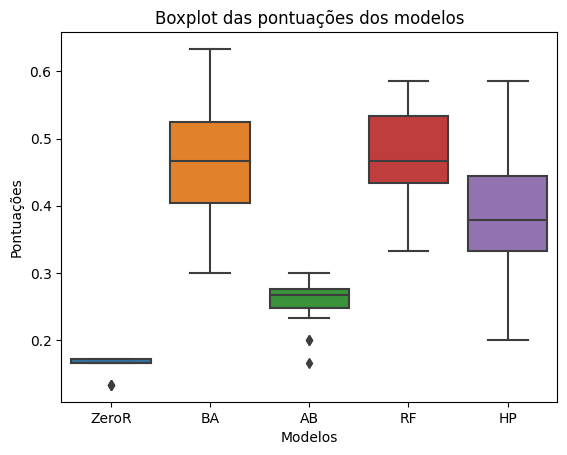

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
#box plot of scores 
sns.boxplot(data=scores).set(xticklabels=nomes_modelos)
plt.title('Boxplot das pontuações dos modelos')
plt.xlabel('Modelos')
plt.ylabel('Pontuações')
plt.show()